## Описание задачи<a
href="#%D0%9E%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8"
class="anchor-link">¶</a>

Задача: <https://task.mos-team.ru/browse/AN-2412>

Посмотреть сценарии бронирования пользователей в сервисе "Библиотеки
Москвы", выделить основные паттерны

## 0. Библиотеки<a
href="#0.-%D0%91%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%B8"
class="anchor-link">¶</a>

In \[1\]:

    #Импортируем необходимые библиотеки

    from datetime import datetime
    from dateutil.relativedelta import relativedelta
    import pandas as pd 
    import numpy as np
    import requests as r
    import re
    from io import BytesIO
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set()
    pd.options.display.float_format = '{:,.2f}'.format
    pd.set_option('display.max_colwidth', None)

In \[2\]:

    date_start = '2023-01-01'

In \[3\]:

    #Подключимся к БД 

    def query(sql_req):
        sql_req = sql_req.encode('utf-8') + b'\nFORMAT CSVWithNames'
        out = r.post(url='https://clh.mos-team.ru:443', data=sql_req, auth=('kobtsevaaa', 'Jdhf9uw98234hrkwjvgh'))
        if out.status_code == 200 and out.text != '':
            return pd.read_csv(BytesIO(out.content))
        else:
            raise Exception(f'\nStatus: {out.status_code}\n{out.text}')

## 1. Подготовка пути пользователя в рамках сессии<a
href="#1.-%D0%9F%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B0-%D0%BF%D1%83%D1%82%D0%B8-%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8F-%D0%B2-%D1%80%D0%B0%D0%BC%D0%BA%D0%B0%D1%85-%D1%81%D0%B5%D1%81%D1%81%D0%B8%D0%B8"
class="anchor-link">¶</a>

In \[4\]:

    #Импортируем файл с расшифровкой 

    dictionary = pd.read_excel('События_расшифровка.xlsx')

In \[5\]:

    #Выведем данные по действиям 

    sessions = query('''with t1 as
    (select *
    from AIS.AIS_books
    where created_at >= \'''' + date_start + '''\'
    order by mos_id, created_at asc)
    select 
        block,
        target,
        event,
        action,
        skind,
        entity,
        link_url,
        link_text,
        link_type,
        suggest_position,
        suggest_type,
        query,
        mos_id,
        toDate(created_at) as date,
        toStartOfQuarter(created_at) as quarter,
        created_at
    from t1
    where mos_id != ''
        and action != 'view'
        ''')

    /tmp/ipykernel_2214901/2562783997.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
      return pd.read_csv(BytesIO(out.content))

In \[6\]:

    #Подсчитаем разницу между логами по пользователям

    sessions['created_at'] = pd.to_datetime(sessions['created_at'])
    sessions['diff'] = sessions.groupby(['mos_id', 'date'])['created_at'].diff()/np.timedelta64(1, 's')
    sessions['diff'] = sessions['diff'].apply(lambda x: 0 if x > 1800 else x)

    #Подсчитаем кумулятивную сумму

    sessions['cum_diff'] = sessions.groupby(['mos_id', 'date'])['diff'].cumsum()
    sessions['prev_cum_diff'] = sessions['cum_diff'].shift(1)

    #Создадим нумерацию сессий 

    sessions = sessions.reset_index().rename(columns = {'index': 'id'})

    #Выведем логи старта сессий

    session_start = sessions[((sessions['cum_diff'] > 1800) & (sessions['prev_cum_diff'] < 1800)) | (sessions['diff'] == 0) | (sessions['cum_diff'].isnull())]
    session_start['session_id'] = session_start['id']

    #Отсортируем айдишки сессий 

    session_start = session_start.sort_values(by = 'id')
    sessions = sessions.sort_values(by = 'id')

    #Соединим данные по сессиям с их стартом (используем спец.функцию). Получаем итоговый результат 

    session_time = pd.merge_asof(sessions, session_start[['id', 'mos_id', 'session_id']], on = 'id', by = 'mos_id')
    session_time.head()

    /tmp/ipykernel_2214901/869449590.py:19: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      session_start['session_id'] = session_start['id']

Out\[6\]:

|     | id  | block        | target | event       | action    | skind | entity | link_url                                                                                         | link_text                                     | link_type | ... | suggest_type | query  | mos_id                   | date       | quarter    | created_at          | diff  | cum_diff | prev_cum_diff | session_id |
|-----|-----|--------------|--------|-------------|-----------|-------|--------|--------------------------------------------------------------------------------------------------|-----------------------------------------------|-----------|-----|--------------|--------|--------------------------|------------|------------|---------------------|-------|----------|---------------|------------|
| 0   | 0   | search_input | link   | navigation  | click     | NaN   | NaN    | /knigi/my-profile/onhands/?page=1                                                                | Кабинет читателя                              | text      | ... | NaN          | NaN    | Cg+IA2O+SiCREg9XDNKTAgA= | 2023-03-03 | 2023-01-01 | 2023-03-03 16:55:15 | NaN   | NaN      | NaN           | 0          |
| 1   | 1   | my_orders    | link   | navigation  | click     | NaN   | NaN    | https://www.mos.ru/otvet-kultura/kak-zapisatsya-v-biblioteku/                                    | Инструкция по оформлению читательского билета | text      | ... | NaN          | NaN    | Cg+IA2O+SiCREg9XDNKTAgA= | 2023-03-03 | 2023-01-01 | 2023-03-03 16:55:25 | 10.00 | 10.00    | NaN           | 0          |
| 2   | 2   | search_input | input  | search      | enter_btn | NaN   | NaN    | NaN                                                                                              | NaN                                           | NaN       | ... | NaN          | clever | Cg+IA2O+VLiREg9XDNl4AgA= | 2023-06-01 | 2023-04-01 | 2023-06-01 12:54:29 | NaN   | NaN      | 10.00         | 2          |
| 3   | 3   | serp         | title  | link_select | click     | NaN   | serp   | https://www.mos.ru/knigi/book/21060/?in_stock=true&is_online=true&in_reading_room=false&library= | Веселая математика                            | NaN       | ... | NaN          | clever | Cg+IA2O+VLiREg9XDNl4AgA= | 2023-06-01 | 2023-04-01 | 2023-06-01 12:54:40 | 11.00 | 11.00    | NaN           | 2          |
| 4   | 4   | book_info    | link   | navigation  | click     | NaN   | NaN    | https://www.mos.ru/pgu/ru/services/link/5020/                                                    | онлайн                                        | text      | ... | NaN          | NaN    | Cg+IA2O+VLiREg9XDNl4AgA= | 2023-06-01 | 2023-04-01 | 2023-06-01 12:55:00 | 20.00 | 31.00    | 11.00         | 2          |

5 rows × 21 columns

In \[7\]:

    #Присвоим основным действиям нейминги, для этого соединим табличку со словарем. Сделаем базовые пути пользователя

    scenarios_all = pd.merge(dictionary, session_time, 
            on = ['block', 'target', 'event', 'entity'], how = 'right')
    scenario_basic = scenarios_all[['mos_id', 'session_id', 'quarter', 'Раздел', 'Действие пользователя', 'query', 'suggest_type_y', 'skind_y']] 
    scenario_basic['Раздел'] = scenario_basic['Раздел'].astype('str')
    scenario_basic['Действие пользователя'] = scenario_basic['Действие пользователя'].astype('str')

    #Идентифицируем события с пустым поиском

    def actions(row):
        x = row['query']
        y = row['Действие пользователя']
        z = row['Раздел']
        if pd.isnull(x) == True and (y == 'Кнопка “Найти”' or 'Ввод поискового запроса' in y) and z == 'Поиск':
            return 'Пустой поиск'
        else:
            return y

    #Соберем таблицы с действиями и разделами по сессиям 

    scenario_basic['Действие пользователя'] = scenario_basic[['query', 'Действие пользователя', 'Раздел']].apply(actions, axis=1)
    scenario_basic1 = scenario_basic.groupby(['session_id', 'mos_id'])['Действие пользователя'].apply(list).reset_index()
    scenarios_pages = scenario_basic.groupby(['session_id', 'mos_id'])['Раздел'].apply(list).reset_index()
    scenarios_basic = pd.merge(scenarios_pages, scenario_basic1, on = ['mos_id', 'session_id'])[['mos_id', 'session_id', 'Раздел', 'Действие пользователя']]
    scenarios_basic['Количество действий'] = scenarios_basic['Действие пользователя'].apply(lambda x: len(x))
    scenarios_basic['Первое действие'] = scenarios_basic['Действие пользователя'].apply(lambda x: x[0])
    scenarios_basic['Последнее действие'] = scenarios_basic['Действие пользователя'].apply(lambda x: x[len(x)-1])
    scenarios_basic['Первый раздел'] = scenarios_basic['Раздел'].apply(lambda x: x[0])

    /tmp/ipykernel_2214901/2547541404.py:6: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      scenario_basic['Раздел'] = scenario_basic['Раздел'].astype('str')
    /tmp/ipykernel_2214901/2547541404.py:7: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      scenario_basic['Действие пользователя'] = scenario_basic['Действие пользователя'].astype('str')
    /tmp/ipykernel_2214901/2547541404.py:22: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      scenario_basic['Действие пользователя'] = scenario_basic[['query', 'Действие пользователя', 'Раздел']].apply(actions, axis=1)

In \[8\]:

    #Среднее кол-во действий за сессию

    max = scenarios_basic['Количество действий'].quantile(0.97) #После разбивки остались еще сессии с большой длительностью - удалим их
    all = scenarios_basic['Количество действий'][scenarios_basic['Количество действий'] <= max].mean()
    print(max, all)

    36.0 6.158674937623042

## 2. Разбивка по сценариям<a
href="#2.-%D0%A0%D0%B0%D0%B7%D0%B1%D0%B8%D0%B2%D0%BA%D0%B0-%D0%BF%D0%BE-%D1%81%D1%86%D0%B5%D0%BD%D0%B0%D1%80%D0%B8%D1%8F%D0%BC"
class="anchor-link">¶</a>

In \[9\]:

    #Распределение по сценариям

    scenarios_basic = scenarios_basic[scenarios_basic['Количество действий'] <= max]

    #Вводим переменную сценарию по действиям (другие сценарии определить не вышло)

    def scenario(row):
        
        x = row['Действие пользователя']
        y = row['Первое действие']
        z = row['Раздел']
        t = row['Первый раздел']
        
        if 'Кнопка “Выбрать библиотеку”' in y:
            return 'Старт с карточки книги'
        if 'Поиск' in z and ('Кнопка “Найти”' in x or 'Ввод поискового запроса' in x) and 'Фильтр “Библиотеки на карте“' not in x and 'Клик по кнопке “Выбрать”' not in x and 'Подсказка “Серия”' not in x and 'Подсказка “Автор”' not in x and 'Подсказка без категории' not in x and 'Подсказка “Книги”' not in x and 'Клик по кнопке “Применить”' not in x:
            return 'Поиск без подсказок'
        if 'Поиск' in z and 'Фильтр “Библиотеки на карте“' not in x and 'Клик по кнопке “Выбрать”' not in x and ('Подсказка “Серия”' in x or 'Подсказка “Автор”' in x or 'Подсказка без категории' in x or 'Подсказка “Книги”' in x) and 'Клик по кнопке “Применить”' not in x:
            return 'Поиск с подсказками'
        if 'Пустой поиск' in x and 'Фильтр “Библиотеки на карте“' not in x and 'Клик по кнопке “Выбрать”' not in x and 'Клик по кнопке “Применить”' not in x:
            return 'Пустой поиск'
        if 'Пустой поиск' in x and ('Фильтр “Библиотеки на карте“' in x or 'Клик по кнопке “Выбрать”' in x or 'Клик по кнопке “Применить”' in x):
            return 'Пустой поиск + фильтр библиотек'
        if 'Поиск' in z and ('Фильтр “Библиотеки на карте“' in x or 'Клик по кнопке “Выбрать”' in x or 'Клик по кнопке “Применить”' in x) and ('Подсказка “Серия”' in x or 'Подсказка “Автор”' in x or 'Подсказка без категории' in x or 'Подсказка “Книги”' in x or 'Кнопка “Найти”' in x or 'Ввод поискового запроса' in x):
            return 'Поиск + фильтр библиотек'
        if 'Пустой поиск' not in x and 'Кнопка “Найти”' not in x and ('Фильтр “Библиотеки на карте“' in x or 'Клик по кнопке “Выбрать”' in x or 'Клик по кнопке “Применить”' in x) and 'Подсказка “Серия”' not in x and 'Подсказка “Автор”' not in x and 'Подсказка без категории' not in x and 'Подсказка “Книги”' not in x:
            return 'Фильтр библиотек'
        if 'Клик по "Продлить"' in x or 'Продление успешно' in x:
            return 'Продление книг'
        if ('Фильтр “Автор”' in x or 'Фильтр “Серия”' in x or 'Фильтр “Тематика”' in x or 'Фильтр “В наличии”' in x or 'Фильтр “Возрастное ограничение”' in x or 'Фильтр “Онлайн бронирование”' in x) and 'Пустой поиск' not in x and 'Кнопка “Найти”' not in x and 'Ввод поискового запроса' not in x and 'Фильтр “Библиотеки на карте“' not in x and 'Подсказка “Серия”' not in x and 'Подсказка “Автор”' not in x and 'Подсказка без категории' not in x and 'Подсказка “Книги”' not in x:
            return 'Фильтры автор/серия/тематика'
        elif 'Кнопка “Избранное”' in x or 'Кнопка “Кабинет читателя”' in x:
            return 'Заход в избранное/кабинет читателя'
        if 'Успешная валидация' in x:
            return 'Валидация ЕЧБ'
        if 'Клик по кнопке “Сохранить”' in x:
            return 'Добавление ЕЧБ'
        elif 'Следующая страница' in y:
            return 'Пагинация'
        elif 'Карта на склейке' in t and 'Ввод поискового запроса' in y:
            return 'Ввод поискового запроса на странице склейки'
        elif 'Кнопка “Забронировать”' in y:
            return 'Бронирование с карты склейки'
        else:
            return 'Другие сценарии'

    #Подсчитаем распределение сессий по сценариям с помощью сводных таблиц
        
    scenarios_basic['Сценарий'] = scenarios_basic[['Действие пользователя', 'Первое действие', 'Раздел', 'Первый раздел']].apply(scenario, axis = 1)
    scenarios_basic['Статус бронирования'] = scenarios_basic['Действие пользователя'].apply(lambda x: 'Забронировал' if 'Подтверждение бронирования ' in x else 'Не забронировал')
    dist_scenarios = scenarios_basic.pivot_table(index = 'Сценарий', values = 'session_id', aggfunc = 'nunique').reset_index().sort_values(by = 'session_id', ascending = False)
    dist_scenarios['Процент'] = round(100*dist_scenarios['session_id']/dist_scenarios['session_id'].sum())
    dist_scenarios

Out\[9\]:

|     | Сценарий                                    | session_id | Процент |
|-----|---------------------------------------------|------------|---------|
| 10  | Продление книг                              | 255712     | 25.00   |
| 9   | Поиск с подсказками                         | 195899     | 19.00   |
| 8   | Поиск без подсказок                         | 186844     | 18.00   |
| 5   | Заход в избранное/кабинет читателя          | 118117     | 11.00   |
| 2   | Ввод поискового запроса на странице склейки | 99518      | 10.00   |
| 4   | Другие сценарии                             | 61919      | 6.00    |
| 7   | Поиск + фильтр библиотек                    | 51044      | 5.00    |
| 14  | Фильтр библиотек                            | 23253      | 2.00    |
| 15  | Фильтры автор/серия/тематика                | 12853      | 1.00    |
| 13  | Старт с карточки книги                      | 4881       | 0.00    |
| 3   | Добавление ЕЧБ                              | 4868       | 0.00    |
| 6   | Пагинация                                   | 4716       | 0.00    |
| 0   | Бронирование с карты склейки                | 3143       | 0.00    |
| 1   | Валидация ЕЧБ                               | 2982       | 0.00    |
| 12  | Пустой поиск + фильтр библиотек             | 2801       | 0.00    |
| 11  | Пустой поиск                                | 1077       | 0.00    |

In \[10\]:

    #Распределение без продлений:

    dist_scenarios_noprolong = dist_scenarios[dist_scenarios['Сценарий'] != 'Продление книг']
    dist_scenarios_noprolong['Процент'] = round(100*dist_scenarios_noprolong['session_id']/dist_scenarios_noprolong['session_id'].sum())
    dist_scenarios_noprolong

    /tmp/ipykernel_2214901/1593633374.py:4: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      dist_scenarios_noprolong['Процент'] = round(100*dist_scenarios_noprolong['session_id']/dist_scenarios_noprolong['session_id'].sum())

Out\[10\]:

|     | Сценарий                                    | session_id | Процент |
|-----|---------------------------------------------|------------|---------|
| 9   | Поиск с подсказками                         | 195899     | 25.00   |
| 8   | Поиск без подсказок                         | 186844     | 24.00   |
| 5   | Заход в избранное/кабинет читателя          | 118117     | 15.00   |
| 2   | Ввод поискового запроса на странице склейки | 99518      | 13.00   |
| 4   | Другие сценарии                             | 61919      | 8.00    |
| 7   | Поиск + фильтр библиотек                    | 51044      | 7.00    |
| 14  | Фильтр библиотек                            | 23253      | 3.00    |
| 15  | Фильтры автор/серия/тематика                | 12853      | 2.00    |
| 13  | Старт с карточки книги                      | 4881       | 1.00    |
| 3   | Добавление ЕЧБ                              | 4868       | 1.00    |
| 6   | Пагинация                                   | 4716       | 1.00    |
| 0   | Бронирование с карты склейки                | 3143       | 0.00    |
| 1   | Валидация ЕЧБ                               | 2982       | 0.00    |
| 12  | Пустой поиск + фильтр библиотек             | 2801       | 0.00    |
| 11  | Пустой поиск                                | 1077       | 0.00    |

In \[11\]:

    #Распределение по сценариям у тех, кто забронировал книгу

    dist_scenarios_reserve = scenarios_basic[scenarios_basic['Статус бронирования'] == 'Забронировал'].pivot_table(index = 'Сценарий', values = 'session_id', aggfunc = 'nunique').reset_index().sort_values(by = 'session_id', ascending = False)
    dist_scenarios_reserve['Процент'] = round(100*dist_scenarios_reserve['session_id']/dist_scenarios_reserve['session_id'].sum())
    dist_scenarios_reserve

Out\[11\]:

|     | Сценарий                                    | session_id | Процент |
|-----|---------------------------------------------|------------|---------|
| 9   | Поиск с подсказками                         | 34025      | 34.00   |
| 8   | Поиск без подсказок                         | 32829      | 32.00   |
| 4   | Другие сценарии                             | 10138      | 10.00   |
| 7   | Поиск + фильтр библиотек                    | 9165       | 9.00    |
| 2   | Ввод поискового запроса на странице склейки | 5761       | 6.00    |
| 5   | Заход в избранное/кабинет читателя          | 2503       | 2.00    |
| 15  | Фильтры автор/серия/тематика                | 1771       | 2.00    |
| 14  | Фильтр библиотек                            | 1486       | 1.00    |
| 0   | Бронирование с карты склейки                | 1375       | 1.00    |
| 13  | Старт с карточки книги                      | 1074       | 1.00    |
| 10  | Продление книг                              | 560        | 1.00    |
| 12  | Пустой поиск + фильтр библиотек             | 282        | 0.00    |
| 6   | Пагинация                                   | 268        | 0.00    |
| 1   | Валидация ЕЧБ                               | 97         | 0.00    |
| 3   | Добавление ЕЧБ                              | 63         | 0.00    |
| 11  | Пустой поиск                                | 36         | 0.00    |

Наиболее популярные сценарии в сервисе: Продление книги, поиск книги как
с подсказками так и без подсказок, Заход в избранное/кабинет читателя.  
Наиболее популярные сценарии в сессиях с бронированием: поиск книги как
с подсказками так и без подсказок, старт с ввода поискового запроса на
странице склейки. В целом топ-сценарии от общего распределения не
отличаются. Люди, которые заходят продлять книгу, как правило не
бронируют другие

## 3. Воронка по сценариям<a
href="#3.-%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D0%BA%D0%B0-%D0%BF%D0%BE-%D1%81%D1%86%D0%B5%D0%BD%D0%B0%D1%80%D0%B8%D1%8F%D0%BC"
class="anchor-link">¶</a>

Построим воронки по сценариям, чтобы понять, с каких шагов уходит больше
всего пользователей

In \[12\]:

    #Соединим таблицу сессии - сценарии с основной таблицей

    list_sc = ['Поиск без подсказок', 'Поиск с подсказками', 'Поиск + фильтр библиотек', 'Фильтр библиотек']
    parameters = scenarios_all[['mos_id', 'session_id', 'block', 'event', 'entity', 'target', 'skind_y', 'suggest_type_y']]
    scenarios_basic = scenarios_basic[['mos_id', 'session_id', 'Сценарий', 'Статус бронирования', 'Раздел', 'Действие пользователя']][scenarios_basic['Сценарий'].isin(list_sc)]
    funnel0 = pd.merge(parameters, scenarios_basic, on = ['session_id', 'mos_id'])

    #Создадим переменную шага воронки

    def steps(row):
        
        x = row['block']
        y = row['event']  

        if y == 'search':
            return 'Поиск книг'
        if x == 'map' and y != 'create_order':
            return 'Выбор библиотеки'
        if y == 'create_order':
            return 'Переходы к бронированию'
        if y == 'reserve_book':
            return 'Подтверждение бронирования'
        
    funnel0['Шаг воронки'] = funnel0[['block', 'event']].apply(steps, axis = 1)
    funnel_agg = funnel0.pivot_table(index = ['Сценарий', 'Шаг воронки'], values = 'session_id', aggfunc = 'nunique').reset_index().sort_values(by = ['Сценарий', 'session_id'], ascending = False)
    funnel_agg

Out\[12\]:

|     | Сценарий                 | Шаг воронки                | session_id |
|-----|--------------------------|----------------------------|------------|
| 12  | Фильтр библиотек         | Выбор библиотеки           | 17655      |
| 15  | Фильтр библиотек         | Поиск книг                 | 14098      |
| 13  | Фильтр библиотек         | Переходы к бронированию    | 1687       |
| 14  | Фильтр библиотек         | Подтверждение бронирования | 1486       |
| 11  | Поиск с подсказками      | Поиск книг                 | 195899     |
| 8   | Поиск с подсказками      | Выбор библиотеки           | 55358      |
| 9   | Поиск с подсказками      | Переходы к бронированию    | 42087      |
| 10  | Поиск с подсказками      | Подтверждение бронирования | 34025      |
| 7   | Поиск без подсказок      | Поиск книг                 | 186844     |
| 4   | Поиск без подсказок      | Выбор библиотеки           | 51579      |
| 5   | Поиск без подсказок      | Переходы к бронированию    | 40472      |
| 6   | Поиск без подсказок      | Подтверждение бронирования | 32829      |
| 3   | Поиск + фильтр библиотек | Поиск книг                 | 51044      |
| 0   | Поиск + фильтр библиотек | Выбор библиотеки           | 36114      |
| 1   | Поиск + фильтр библиотек | Переходы к бронированию    | 10268      |
| 2   | Поиск + фильтр библиотек | Подтверждение бронирования | 9165       |

In \[13\]:

    #Выведем воронки по сценариям 

    for i in list_sc:
        y = [4,3,2,1]
        x = round(funnel_agg[funnel_agg['Сценарий'] == i]['session_id']/1000).to_list()
        x_max = 200
        x_min = 0
        fig, ax = plt.subplots(1, figsize=(12,6))
        for idx, val in enumerate(x):
            left = (x_max - val)/2
            plt.barh(y[idx], x[idx], left = left, height=1, edgecolor='black')
            plt.text(50, y[idx], x[idx], ha='center',
                 fontsize=16, color='#2A2A2A')
        plt.axis('off')
        plt.xlim(x_min, x_max)
        plt.title('Воронка по сценарию ' + '"' + i + '"' + ' в тыс.')

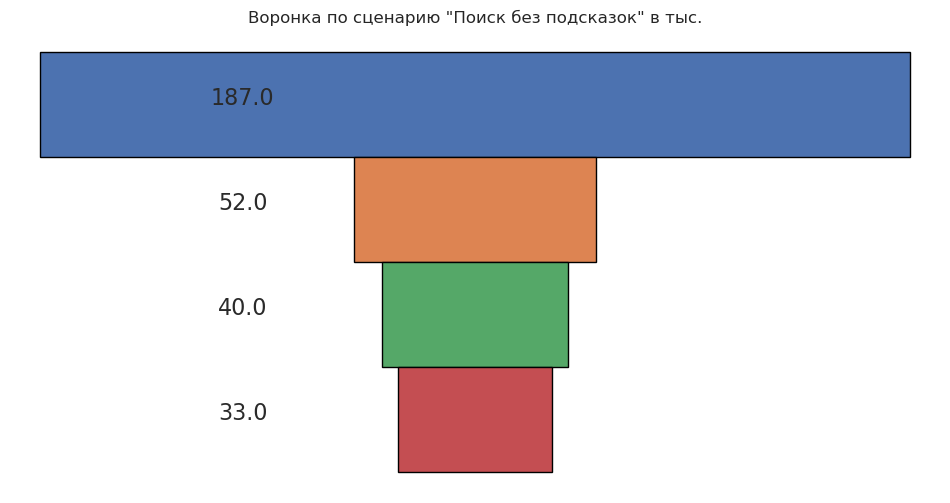

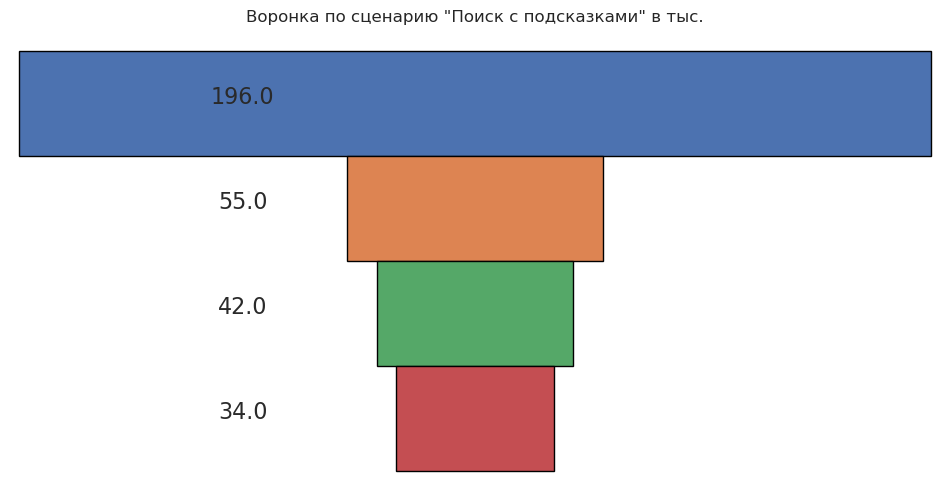

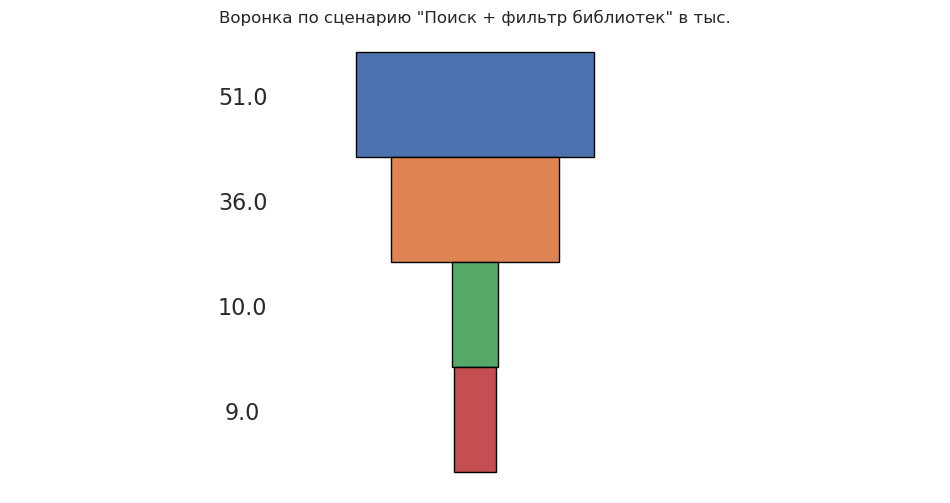

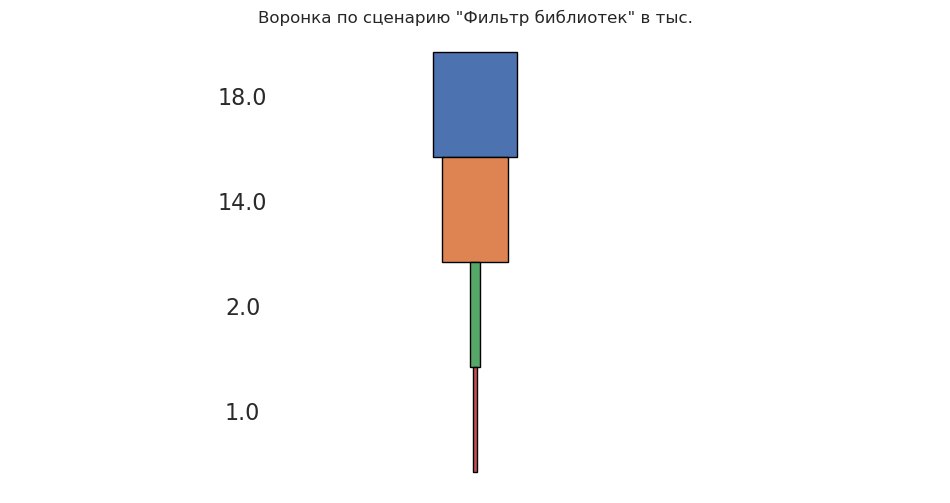

Как видно по воронкам, в зависимости от сценариев шаги, с которых уходит
больше пользователей, различаются:

1.  Пустой поиск, Поиск без подсказок, Поиск с подсказками: большая
    часть пользователей уходит с шага "поиск" (каталог). Возможная
    причина: пользователи, идущие по данным сценариям, предпочитают
    искать книгу напрямую без фильтров и их интересует удобство поиска
2.  Поиск, фильтр библиотек: большая часть пользователей уходит с шага
    "выбор библиотеки" (страница склейки). Возможная причина:
    пользователи, идущие по данным сценариям, предпочитают выбирать
    сразу библиотеку, и на странице склейки они снова вынуждены тратить
    свое время на выбор библиотеки - для них это затруднительно

## 4. Поведение пользователей, которые не забронировали книгу: поиск, фильтры, страница склейки<a
href="#4.-%D0%9F%D0%BE%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9,-%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D1%8B%D0%B5-%D0%BD%D0%B5-%D0%B7%D0%B0%D0%B1%D1%80%D0%BE%D0%BD%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BB%D0%B8-%D0%BA%D0%BD%D0%B8%D0%B3%D1%83:-%D0%BF%D0%BE%D0%B8%D1%81%D0%BA,-%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D1%8B,-%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0-%D1%81%D0%BA%D0%BB%D0%B5%D0%B9%D0%BA%D0%B8"
class="anchor-link">¶</a>

In \[14\]:

    #Распределение по подсказкам 

    nonreserve = funnel0[funnel0['Статус бронирования'] == 'Не забронировал']
    suggests = nonreserve[nonreserve['suggest_type_y'] != ''].pivot_table(index = 'suggest_type_y', values = 'session_id', aggfunc = 'nunique')
    suggests                                                              

Out\[14\]:

|                 | session_id |
|-----------------|------------|
| suggest_type_y  |            |
| Книги           | 82084      |
| Поиск           | 2206       |
| Поиск по автору | 87763      |
| Поиск по серии  | 29900      |

Наиболее популярная подсказка, которой пользуются пользователи, не
забронировавшие книгу - Поиск по автору, второе по популярности - Поиск
по книге

In \[15\]:

    #Топ фильтров

    filters = nonreserve[(nonreserve['event'] == 'search') & (nonreserve['block'] == 'filters')].pivot_table(index = 'entity', values = 'session_id', aggfunc = 'nunique')
    filters     

Out\[15\]:

|              | session_id |
|--------------|------------|
| entity       |            |
| age_limit    | 1586       |
| author       | 6178       |
| in_stock     | 4177       |
| is_online    | 5793       |
| lang         | 851        |
| library      | 33771      |
| pb_type      | 810        |
| pb_year_from | 2825       |
| pb_year_to   | 1034       |
| publisher    | 2019       |
| serial       | 2283       |
| sort         | 3552       |
| theme        | 3565       |

Наиболее популярный фильтр - Библиотеки

In \[16\]:

    #Страница склейки - посмотрим как себя ведут пользователи на ней 

    page_book0 = nonreserve[(nonreserve['block'] == 'book_info') | (nonreserve['block'] == 'map')]
    page_book = pd.merge(page_book0, dictionary, on = ['block', 'event', 'entity'])
    page_book = page_book[['mos_id', 'session_id', 'block', 'event', 'entity', 'skind', 'Действие пользователя_y']]
    page_book_routes = page_book.groupby(['mos_id', 'session_id'])['Действие пользователя_y'].agg(list).reset_index()
    page_book_routes['Последнее действие'] = page_book_routes['Действие пользователя_y'].apply(lambda x: x[len(x)-1])

In \[17\]:

    page_book_finish = page_book_routes.groupby('Последнее действие')['session_id'].agg('nunique').reset_index().sort_values('session_id', ascending = False)
    page_book_finish['Доля'] = round(100*page_book_finish['session_id']/page_book_finish['session_id'].sum())
    page_book_finish

Out\[17\]:

|     | Последнее действие                       | session_id | Доля  |
|-----|------------------------------------------|------------|-------|
| 0   | Ввод поискового запроса                  | 55162      | 49.00 |
| 5   | Кнопка “Выбрать библиотеку”              | 33046      | 29.00 |
| 6   | Кнопка “Забронировать”                   | 14759      | 13.00 |
| 7   | Фильтр “В наличии”                       | 4511       | 4.00  |
| 8   | Фильтр “Онлайн бронирование”             | 1979       | 2.00  |
| 4   | Клик по “онлайн” в условиях бронирования | 1756       | 2.00  |
| 1   | Выбор издания. Кнопка “X”                | 1006       | 1.00  |
| 3   | Выбор издания. Кнопка “Применить”        | 1006       | 1.00  |
| 2   | Выбор издания. Кнопка “Отменить”         | 477        | 0.00  |

In \[ \]:

     

Большая часть пользователей уходит после действия 'Ввод поискового
запроса': скорее всего, данная группа пользователей пыталась найти
библиотеку в поисковой строке карты, но у них не получилось. Вторая
группа: вероятно увидели список библиотек (3-10) и поняли, что они им не
подходят. Еще видим, что в 13% визитов на данном этапе воронки
пользователи переходят к бронированию, но его не завершают

## 5. Поведение пользователей, которые забронировали книгу: поиск, фильтры, страница склейки<a
href="#5.-%D0%9F%D0%BE%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9,-%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D1%8B%D0%B5-%D0%B7%D0%B0%D0%B1%D1%80%D0%BE%D0%BD%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BB%D0%B8-%D0%BA%D0%BD%D0%B8%D0%B3%D1%83:-%D0%BF%D0%BE%D0%B8%D1%81%D0%BA,-%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D1%8B,-%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0-%D1%81%D0%BA%D0%BB%D0%B5%D0%B9%D0%BA%D0%B8"
class="anchor-link">¶</a>

In \[18\]:

    #Распределение по подсказкам

    reserve = funnel0[funnel0['Статус бронирования'] == 'Забронировал']
    suggests2 = reserve[reserve['suggest_type_y'] != ''].pivot_table(index = 'suggest_type_y', values = 'session_id', aggfunc = 'nunique')
    suggests2                

Out\[18\]:

|                 | session_id |
|-----------------|------------|
| suggest_type_y  |            |
| Книги           | 23383      |
| Поиск           | 734        |
| Поиск по автору | 13750      |
| Поиск по серии  | 6153       |

Наиболее популярная подсказка, которой пользуются пользователи,
забронировавшие книгу - Поиск по книге (отличается от тех, кто не
забронировал книгу)

In \[19\]:

    #Топ фильтров

    filters2 = reserve[(reserve['event'] == 'search') & (reserve['block'] == 'filters')].pivot_table(index = 'entity', values = 'session_id', aggfunc = 'nunique')
    filters2     

Out\[19\]:

|              | session_id |
|--------------|------------|
| entity       |            |
| age_limit    | 600        |
| author       | 1325       |
| in_stock     | 378        |
| is_online    | 525        |
| lang         | 150        |
| library      | 8491       |
| pb_type      | 148        |
| pb_year_from | 735        |
| pb_year_to   | 187        |
| publisher    | 501        |
| serial       | 442        |
| sort         | 591        |
| theme        | 755        |

Здесь выбиваются два фильтра по популярности - Библиотеки и Автор

In \[20\]:

    #Среднее кол-во выбранных библиотек в фильтрах

    libraries = reserve[(reserve['block'] == 'filters') & (reserve['event'] == 'select') & (reserve['entity'] == 'library') & (reserve['target'] == 'button')][['session_id', 'skind_y']]
    libraries['Кол-во библиотек'] = libraries['skind_y'].apply(lambda x: len(x)/9 if len(x) == 9 else len(x)/10)
    libraries_dist0 = libraries.pivot_table(index = 'session_id', values = 'Кол-во библиотек', aggfunc = 'sum').reset_index()
    libraries_dist = libraries_dist0.pivot_table(index = 'Кол-во библиотек', values = 'session_id', aggfunc = 'nunique')
    libraries_dist

Out\[20\]:

|                  | session_id |
|------------------|------------|
| Кол-во библиотек |            |
| 1.00             | 4879       |
| 2.00             | 803        |
| 3.00             | 181        |
| 4.00             | 39         |
| 5.00             | 15         |
| 6.00             | 9          |
| 7.00             | 2          |
| 8.00             | 2          |
| 9.00             | 1          |

Большая часть пользователей выбирает 1 библиотеку (80%), 2 библиотеки -
15%

In \[21\]:

    #Страница склейки: статистика по доставкам

    book_reserves = reserve[(reserve['block'] == 'book_info') | (reserve['block'] == 'map')]['session_id'].nunique()
    book_deliveries = reserve[(reserve['event'] == 'delivery_order')]['session_id'].nunique()
    print('Доля визитов с выбором доставки: ', round(100*book_deliveries/book_reserves))

    Доля визитов с выбором доставки:  0

## 6. Выбор библиотек (одна/разные)<a
href="#6.-%D0%92%D1%8B%D0%B1%D0%BE%D1%80-%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA-(%D0%BE%D0%B4%D0%BD%D0%B0/%D1%80%D0%B0%D0%B7%D0%BD%D1%8B%D0%B5)"
class="anchor-link">¶</a>

Далее посмотрим на приверженность пользователей к определенным
библиотекам

In \[22\]:

    #Выведем данные по заказам от АБИСА

    orders = query('''
    select chitatel, biblioteka, count(biblioteka) as number_bibl
    from EXTERNAL.EXTERNAL_ALL_SABOT_knigiorders35009935
    where toDate(parseDateTimeBestEffortOrNull(data_sozdaniia)) >= \'''' + date_start + '''\'
    and istochnik = 'Читатель'
    group by chitatel, biblioteka
    having count(chitatel) > 1
        ''')

In \[23\]:

    #Распределение по кол-ву библиотек, где пользователи берут заказы 

    libraries = orders.pivot_table(index = 'chitatel', values = 'biblioteka', aggfunc = 'nunique').reset_index()
    one_library = round(100*libraries[libraries['biblioteka'] == 1]['chitatel'].nunique()/libraries['chitatel'].nunique())
    two_libraries = round(100*libraries[libraries['biblioteka'] == 2]['chitatel'].nunique()/libraries['chitatel'].nunique())
    three_libraries = round(100*libraries[libraries['biblioteka'] == 3]['chitatel'].nunique()/libraries['chitatel'].nunique())
    print('Доля пользователей, бронирующих книги в 1 библиотеке: ', one_library)
    print('Доля пользователей, бронирующих книги в 2 библиотеках: ', two_libraries)
    print('Доля пользователей, бронирующих книги в 3 библиотеках: ', three_libraries)

    Доля пользователей, бронирующих книги в 1 библиотеке:  78
    Доля пользователей, бронирующих книги в 2 библиотеках:  15
    Доля пользователей, бронирующих книги в 3 библиотеках:  4

In \[29\]:

    #Посмотрим, как пользователи бронируют книги в библиотеках (топ-библиотек, где бронируют)

    libraries_info = pd.merge(libraries[libraries['biblioteka'] > 1]['chitatel'], orders, on = ['chitatel'])
    libraries_info_pivot = libraries_info.pivot_table(index = ['chitatel', 'biblioteka'], values = 'number_bibl', aggfunc = 'sum').reset_index()
    libraries_more_1 = libraries_info_pivot[libraries_info_pivot['number_bibl'] > 1].sort_values(by = ['chitatel', 'number_bibl'], ascending = False)
    libraries_more_1_sum = libraries_more_1.pivot_table(index = 'chitatel', values = 'number_bibl', aggfunc = 'sum').reset_index()
    libraries_more_1_sum = libraries_more_1_sum.rename(columns = {'number_bibl': 'sum_number'})
    libraries_final = pd.merge(libraries_more_1, libraries_more_1_sum, on = ['chitatel'])
    libraries_final = libraries_final[['chitatel', 'biblioteka', 'number_bibl', 'sum_number']].sort_values(by = ['chitatel', 'number_bibl'], ascending = False)
    libraries_final['share'] = round(100*libraries_final['number_bibl']/libraries_final['sum_number'])
    libraries_final

Out\[29\]:

|       | chitatel             | biblioteka                              | number_bibl | sum_number | share |
|-------|----------------------|-----------------------------------------|-------------|------------|-------|
| 0     | 9,990,000,633,326.00 | ОКЦ ВАО                                 | 2           | 4          | 50.00 |
| 1     | 9,990,000,633,326.00 | ОКЦ ЮВАО                                | 2           | 4          | 50.00 |
| 2     | 9,990,000,629,114.00 | ОКЦ СВАО                                | 2           | 4          | 50.00 |
| 3     | 9,990,000,629,114.00 | ОКЦ ЮЗАО                                | 2           | 4          | 50.00 |
| 4     | 9,990,000,628,483.00 | Дом Гоголя                              | 2           | 4          | 50.00 |
| ...   | ...                  | ...                                     | ...         | ...        | ...   |
| 10813 | 190,000,034,454.00   | Библиотека-читальня им. И.С. Тургенева  | 11          | 38         | 29.00 |
| 10814 | 190,000,034,454.00   | Библиотека искусств им. А.П. Боголюбова | 6           | 38         | 16.00 |
| 10815 | 190,000,034,454.00   | ОКЦ ЮАО                                 | 4           | 38         | 11.00 |
| 10816 | 190,000,010,502.00   | ОКЦ ЦАО                                 | 8           | 10         | 80.00 |
| 10817 | 190,000,010,502.00   | ЦГМБ им. М.А. Светлова                  | 2           | 10         | 20.00 |

10818 rows × 5 columns

In \[32\]:

    libraries_final['prev_share'] = libraries_final.groupby('chitatel')['share'].shift(1)
    libraries_final = libraries_final.dropna()
    libraries_final['diff'] = libraries_final['share'] - libraries_final['prev_share']
    libraries_final

    /tmp/ipykernel_2214901/702806684.py:3: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      libraries_final['diff'] = libraries_final['share'] - libraries_final['prev_share']

Out\[32\]:

|       | chitatel             | biblioteka                              | number_bibl | sum_number | share | diff   | prev_share |
|-------|----------------------|-----------------------------------------|-------------|------------|-------|--------|------------|
| 1     | 9,990,000,633,326.00 | ОКЦ ЮВАО                                | 2           | 4          | 50.00 | 0.00   | 50.00      |
| 3     | 9,990,000,629,114.00 | ОКЦ ЮЗАО                                | 2           | 4          | 50.00 | 0.00   | 50.00      |
| 5     | 9,990,000,628,483.00 | ОКЦ ВАО                                 | 2           | 4          | 50.00 | 0.00   | 50.00      |
| 7     | 9,990,000,627,752.00 | ОКЦ ЮАО                                 | 5           | 17         | 29.00 | -24.00 | 53.00      |
| 8     | 9,990,000,627,752.00 | Дом Гоголя                              | 3           | 17         | 18.00 | -11.00 | 29.00      |
| ...   | ...                  | ...                                     | ...         | ...        | ...   | ...    | ...        |
| 10811 | 190,000,034,492.00   | ОКЦ ЗАО                                 | 2           | 7          | 29.00 | -42.00 | 71.00      |
| 10813 | 190,000,034,454.00   | Библиотека-читальня им. И.С. Тургенева  | 11          | 38         | 29.00 | -16.00 | 45.00      |
| 10814 | 190,000,034,454.00   | Библиотека искусств им. А.П. Боголюбова | 6           | 38         | 16.00 | -13.00 | 29.00      |
| 10815 | 190,000,034,454.00   | ОКЦ ЮАО                                 | 4           | 38         | 11.00 | -5.00  | 16.00      |
| 10817 | 190,000,010,502.00   | ЦГМБ им. М.А. Светлова                  | 2           | 10         | 20.00 | -60.00 | 80.00      |

6567 rows × 7 columns

In \[36\]:

    #Выведем распределение читателей по разницам в % заказов между библиотеками 
    libraries_final['diff'].hist(bins = 30)

Out\[36\]:

    <Axes: >

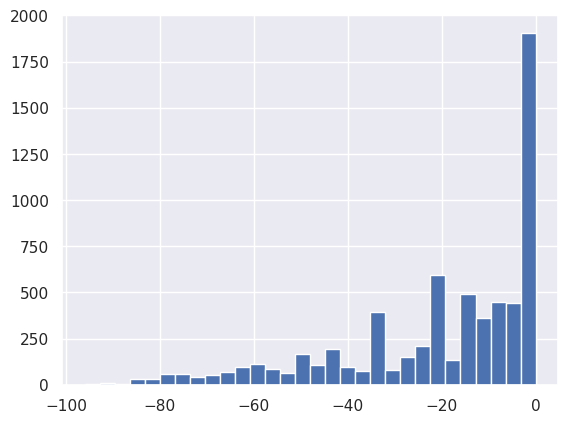

In \[37\]:

    different_libraries_share = round(100*libraries_final[abs(libraries_final['diff']) <= 10]['chitatel'].nunique()/libraries_final['chitatel'].nunique())
    top_libraries_share = round(100*libraries_final[abs(libraries_final['diff']) >= 30]['chitatel'].nunique()/libraries_final['chitatel'].nunique())
    print('Доля пользователей, имеющих топ-библиотек: ', top_libraries_share)
    print('Доля пользователей, бронирующие книги в разных библиотеках: ', different_libraries_share)

    Доля пользователей, имеющих топ-библиотек:  43
    Доля пользователей, бронирующие книги в разных библиотеках:  44

43% пользователей имеют явную/явные топы библиотек (разница в 30% между
библиотеками по доле заказов)  
44% пользователей бронируют книги в разных библиотеках (разница в 10%
между библиотеками по доле заказов)

## 7\*. Retention rate сервиса<a href="#7*.-Retention-rate-%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D0%B0"
class="anchor-link">¶</a>

In \[25\]:

    #Все заказы за 2023 

    bookings_2023 = query('''
    select chitatel, toDate(parseDateTimeBestEffortOrNull(data_sozdaniia)) as date
    from EXTERNAL.EXTERNAL_ALL_SABOT_knigiorders35009935
    where toDate(parseDateTimeBestEffortOrNull(data_sozdaniia)) >= \'''' + date_start + '''\'
    and istochnik = 'Читатель'
        ''')

In \[26\]:

    #Подсчитаем ретеншен (заказы в разные даты)

    bookings_dist = bookings_2023.pivot_table(index = 'chitatel', values = 'date', aggfunc = 'nunique').reset_index()
    retention_rate = round(100*bookings_dist[bookings_dist['date'] > 1]['chitatel'].nunique()/bookings_dist['chitatel'].nunique())
    retention_rate                                                                                                              

Out\[26\]:

    52